# Intro

Dear Kagglers,

The Kiva organization presents individuals with the ability to positively impact the world through micro lending. By sharing some of their data online, Kiva is presenting data science enthusiasts with the opportunity to use their skills for improving the impact of the organization's charitable activities. Specifically, we are encouraged to use Kiva's dataset in one of two ways:

* Find new datasets to enrich the historic records of Kiva loans for the last two years.
* Based on the enriched data, build a poverty score for each loan.
* Describe the integration and scoring process so that Kiva personnel can implement it.

The requirements for the the dataset and the performed work are the following:

* The data should be as granular as possible
* The data shoud cover as many geographic regions as possible
* The data should be credible
* The poverty score should correspond to each loan's unique parameters (location and gender of the borrower).

This will hopefully allow Kiva to focus their effort in improving the conditions of those specific regions.

In this notebook, we'll make an attempt to address (although not in full) most of the requirements of the Kiva challenge and help them identify underserved individuals.

In [1]:
#numeric
import numpy as np
import pandas as pd

#visualization
import matplotlib.pyplot as plt
import seaborn as sns
import folium

from IPython.display import display

plt.style.use('bmh')
%matplotlib inline
plt.rcParams['figure.figsize'] = (14, 10)
plt.rcParams['axes.titlepad'] = 25
sns.set_color_codes('pastel')

#Pandas warnings
import warnings
warnings.filterwarnings('ignore')

#system
import os
print(os.listdir("../"));

['experiments', 'kaggle_quora_competition', 'kiva_ph_poverty_score', 'lectures', 'TODO_dermatologist_ai', 'udacity_cnn', 'udacity_mlnd_boston_housing', 'udacity_mlnd_charity_ml', 'udacity_mlnd_customer_segments', 'udacity_mlnd_dog_recognizer']


# Region Selection

We'll start by identifying the 5 most important regions for Kiva. This will help us focus with our selection of supplementary datasets. To do that, we'll:

1. Import the `kiva_loans.csv` file
2. Group the loans by country and count the number of rows for each country
3. We'll sort the dataframe from step 2 and 3 by country and select the top 5 entries by their count values

In [2]:
all_loans = pd.read_csv('kiva_loans.csv', index_col = 0)
all_loans.drop(['activity', 'use', 'country_code', 'posted_time', 'disbursed_time', 'funded_time', 'date', 'lender_count', 'tags'], axis = 1, inplace = True)

In [3]:
count_loans = all_loans[['country', 'loan_amount']].groupby(by = 'country').count().reset_index()
count_loans.rename(columns = {'loan_amount' : 'num_loans'}, inplace = True)

<Container object of 5 artists>

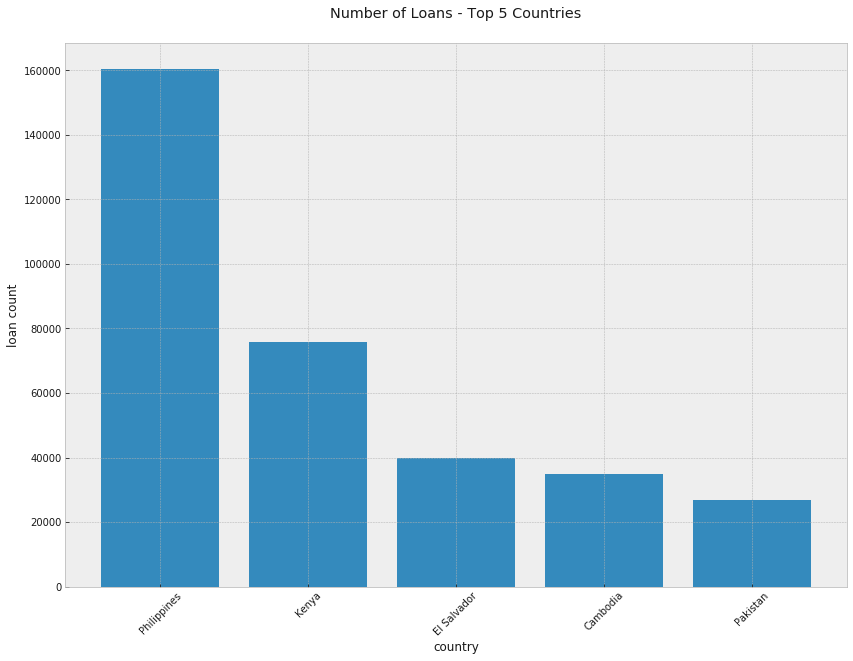

In [4]:
to_plot = count_loans.sort_values(by = 'num_loans', ascending = False)[:5]
x_ticks = np.arange(len(to_plot))
plt.xticks(x_ticks, to_plot.country, rotation = 45)
plt.ylabel('loan count')
plt.xlabel('country')
plt.title('Number of Loans - Top 5 Countries')
plt.bar(x_ticks, to_plot.num_loans)

As we can see, the Philippines is the region where Kiva mostly focuses their efforts in terms of loan count. Actually, when it comes to loan count, there are twice as many loans granted in the Phillipines as in the second country in the list (Kenya). This leads us to some important considerations, namely that:

* Data with the widest possible coverage (World Bank, UN statistics, CIA World Factbook) is averaged out for each country and does not present a nuanced enough picture of the poverty levels. That is, in countries with high GINI coefficient, the average levels tell us little about the actual poverty-affected regions.
* Local country data is presented in different formats. Every country measures different macroeconomic indicators (and sometimes measures the same indicators in different ways). This makes local data, that could eventually be joined together on global level, unreliable. Example: some countries may consider 'unemployment' as the number of working age individuals with no regular employment contract as unemployed. Other countries may consider 'unemployment' as individuals who do not have a regular employment contract AND are looking for employment (i.e. individuals who are not actively looking for jobs are not counted).

To address these problems, we can:

* Take a local to global approach instead of vice versa. That is, we'll start by creating a model that captures the poverty variations within a country with good enough data. The model can then accept new data from other countries and scale up. The more countries, the more global the poverty score.
* We can use census or survey data (where available) in order to derive our own indicators. Census and survey data usually presents us with quite raw indicators (e.g. number of family members, household income, etc.). However, census data is hard to come by.

Luckily for us, there is an excellent dataset from the Philippine Statistics Authority published here on Kaggle. Not only is it segmented by region, but also contains data about the gender of the household head. This presents us with a great opportunity to focus on the most important region for Kiva and produce a working poverty model that could later on be scaled up. If our experiment is successful, more time could be invested to search and add further census data results from other countries and scale up the model. The dataset in question is the [Family Income and Expenditure Survey (FIES)](https://www.kaggle.com/grosvenpaul/family-income-and-expenditure).

# Modelling Approach
In order to produce a model for the poverty score, we need to:

1. Clean and prepare the the FIES data (e.g. convert categorical text fields to dummy variables, map regions to universal naming convention, etc.). We have already performed that work in [a separate notebook](https://www.kaggle.com/rossrco/philippines-fies-data-cleanup). At this point, we'll just import the results from that data transformation work.
2. Map the province from the `region` field of the `kiva_loans.csv` data. This is a no easy task. The region field contains unstructured data that:
    * Sometimes represents the name of the administrative center of a region and the region name (e.g. 'Tanjay, Negros Oriental')
    * Sometimes represents the name of a population center (e.g. 'Plaridel-Cebulin')
    * Sometimes contains very local names (e.g. the name of a village)
    * Sometimes is missing

However, the most common patter in the c.a. 160 000 Philippine loans is a name of a city, followed by a name of a province. We used that and some other heueristics to quickly map 150 000 loans to provinces in the Philippines. This allows us to join the poverty score results based on the FIES data to the loan data on province and household head gender. The mapping work for the province of each Kiva loan is performed in [a separate notebook](https://www.kaggle.com/rossrco/kiva-loans-philippines-region-matching). At this point, we'll just import the results from that work.

3. We will attempt to predict a scaled version of the `household_income` field from the FIES data.
4. We will try to reduce the number of input variables to the model but affect its accuracy as little as possible. __We will attempt to use 3-5 trivial variables. This will allow Kiva to add such variables to their loan application form and quickly get an estimate of the poverty level of each borrower.__
5. We'll invert the income prediction to derive poverty. At first this will give us highly localized poverty scores (the scores will be relative to the highest income in the Philippines). However, if this initial model is scaled up with data from more countries, the poverty score will become relative to a more global income estimate. That is, the highest poverty score will be inverse to the highest incomes. This could produce a good global metric. Example: if a country has a low median income compared to a group  of developed nations, the local poverty score would be low. But as more incomes are added and the poverty model updated and scaled up, the poverty scores of that country will rise as higher incomes are introduced for comparison.

In [5]:
loans_ph = pd.read_csv('kiva_loans_ph_transofrmed.csv', index_col = 0)

In [6]:
income_ph = pd.read_csv('philippines_census_data_cl.csv', index_col = 0)

## Data Selection
We'll start off by converting the region labels to one-hote encoded columns. We'll subsequently print the list of these columns and consider the types of data we could use.

In [7]:
income_ph_model = income_ph.join(pd.get_dummies(income_ph.region))
income_ph_model.drop('region', axis = 1, inplace = True)

In [8]:
income_ph_model.columns

Index(['household_income', 'food_expenses', 'agricultural_household',
       'clothing_expenses', 'house_and_water_expenses', 'house_rental_value',
       'medical_expenses', 'transport_expenses', 'comm_expenses',
       'education_expenses', 'misc_expenses', 'special_occasion_expenses',
       'farming_gardening_expenses', 'income_from_entrepreneur_activities',
       'house_head_sex_f', 'house_head_age', 'house_head_empl',
       'num_family_members', 'num_children_younger_5', 'num_children_older_5',
       'num_family_members_employed', 'house_area', 'house_age',
       'num_bedrooms', 'electricity', 'num_refrigerator', 'num_wash_machine',
       'num_ac', 'num_stove', 'main_inc_entrepreneur', 'main_inc_other',
       'main_inc_wage', 'non_essential_expenses', 'house_head_partner',
       'house_head_single', 'house_head_illiterate', 'house_head_primary_ed',
       'house_head_secondary_ed', 'house_head_tertiary_ed',
       'house_head_farmer', 'house_ext_family', 'house_mult_family

As we can see, there are several columns that would correlate highly with the 'household_income' column. Those are:

* 'income_from_entrepreneur_activities'
* 'main_inc_entrepreneur'
* 'main_inc_other'
* 'main_inc_wage'

Let's see the actual correlation levels and confirm that:

In [9]:
inc_corr = income_ph_model[['household_income',
                            'income_from_entrepreneur_activities',
                            'main_inc_entrepreneur',
                            'main_inc_other',
                            'main_inc_wage']].corr()
inc_corr

,household_income,income_from_entrepreneur_activities,main_inc_entrepreneur,main_inc_other,main_inc_wage
household_income,1.000000,0.563662,-0.068279,-0.010181,0.067958
income_from_entrepreneur_activities,0.563662,1.000000,0.363651,-0.106587,-0.220697
main_inc_entrepreneur,-0.068279,0.363651,1.000000,-0.341511,-0.564373
main_inc_other,-0.010181,-0.106587,-0.341511,1.000000,-0.583149
main_inc_wage,0.067958,-0.220697,-0.564373,-0.583149,1.000000


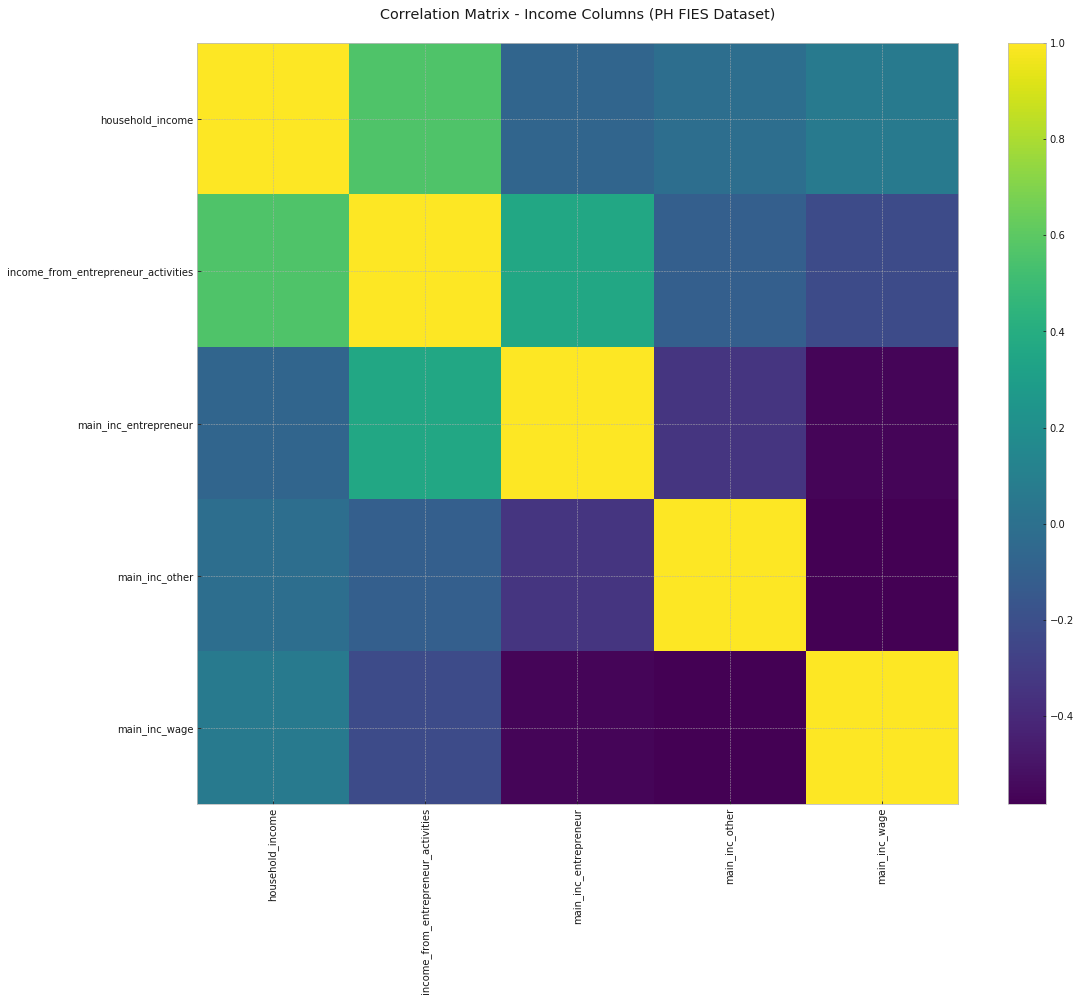

In [10]:
fig = plt.figure(figsize = (18, 14))
plt.xticks(np.arange(len(inc_corr.columns)), inc_corr.columns, rotation = 90)
plt.yticks(np.arange(len(inc_corr.index)), inc_corr.index)
plt.title('Correlation Matrix - Income Columns (PH FIES Dataset)')
plt.imshow(inc_corr)
plt.colorbar()

At this point, we'll remove the correlating income columns and investigate some of the other correlating patterns.

In [11]:
income_ph_model.drop(['income_from_entrepreneur_activities',
                      'main_inc_entrepreneur',
                      'main_inc_other',
                      'main_inc_wage'],
                     axis = 1,
                     inplace = True)

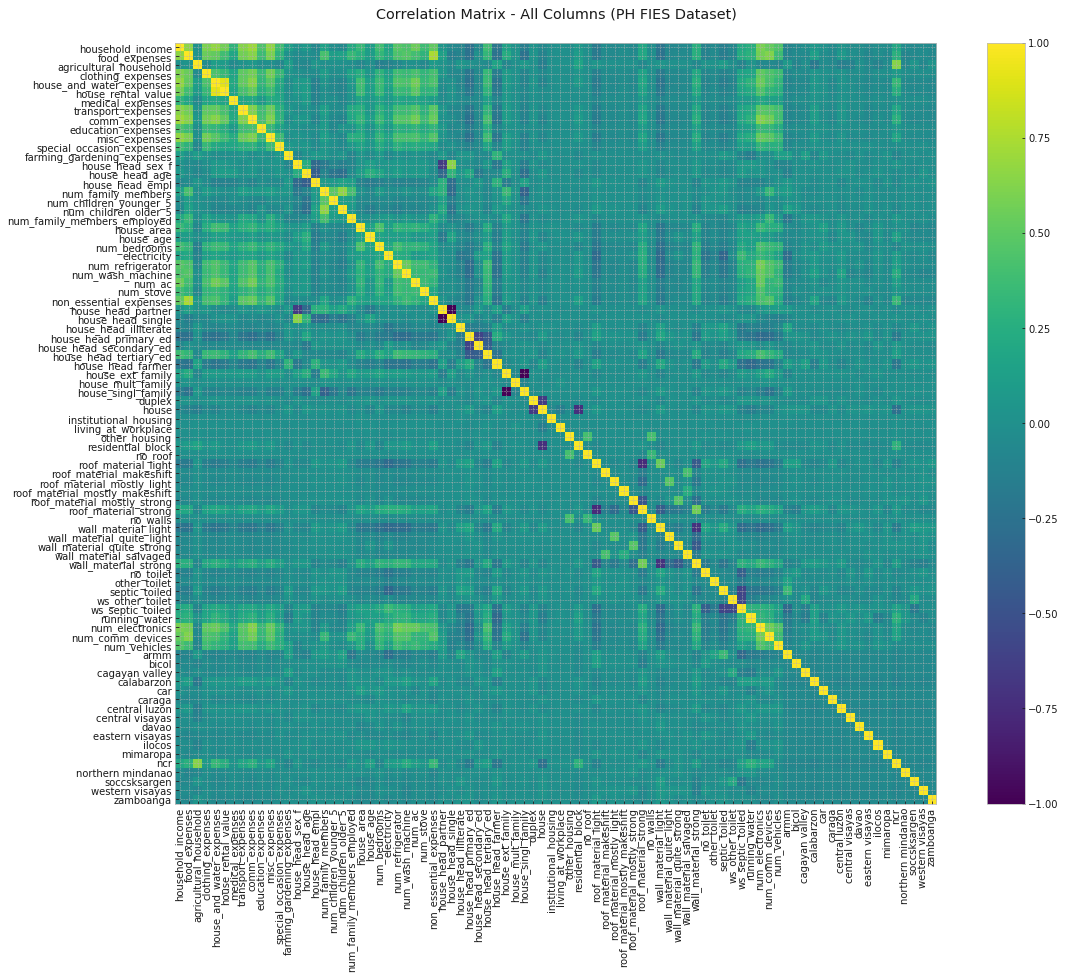

In [12]:
fig = plt.figure(figsize = (18, 14))
plt.title('Correlation Matrix - All Columns (PH FIES Dataset)')
plt.xticks(np.arange(len(income_ph_model.corr().columns)), income_ph_model.corr().columns, rotation = 90)
plt.yticks(np.arange(len(income_ph_model.corr().index)), income_ph_model.corr().index)
plt.imshow(income_ph_model.corr())
plt.colorbar()

As we can see, there are some high positive and some inverse correlations. Let's zoom in on several examples:

* The expenses columns seem to correlate highly with one another. That is reasonable as high 'transportation' or 'other' expenses indicate an affluent household. We could expect such a household to also have high 'clothing' expenses.
* There are some inversely-correlating columns (e.g. `house_head_single` and `house_head_parther`). The relationship there is more than obvious - if the house head is single, they definitely don't have a partner.
* The `household_income` column seems to correlate highly with the following fields:
    * Expenses (food expenses, clothing expenses, house and water expenses, transport expenses, communication expenses and miscellaneous expenses)
    * House rental value
    * Number of ACs (air conditioning appliances)
    * Number of electronic devices (DVDs, CD, stereo, etc.)
    * Number of communication devices (landline or mobile phones)
    * Number of vehicles (cars, tricycles, motorized boats)

Those correlations seem to reasonably point towards the welfare of individuals. After all, poverty is not only the lack of disposable income, but also exclusion through lack of connectivity, transportation and financing.

At this point, we will:

* Visualize the correlation of the expenses
* Remove one of each inversely-correlating pairs
* Remove the non-relevant expenses. The reason for that is to make the model less reliant on information from the same category. This will also allow us to require less data if we scale the model internationally (it will be way easier to find food expenses data alone than food, clothing, miscellaneous, transportation, etc. together).

In [13]:
expense_corr = income_ph_model[['food_expenses',
                                'clothing_expenses',
                                'house_and_water_expenses', 
                                'medical_expenses',
                                'transport_expenses',
                                'comm_expenses',
                                'education_expenses',
                                'misc_expenses',
                                'special_occasion_expenses',
                                'farming_gardening_expenses',
                                'non_essential_expenses']].corr()
expense_corr

,food_expenses,clothing_expenses,house_and_water_expenses,medical_expenses,transport_expenses,comm_expenses,education_expenses,misc_expenses,special_occasion_expenses,farming_gardening_expenses,non_essential_expenses
food_expenses,1.000000,0.543237,0.522252,0.186645,0.577372,0.633819,0.374898,0.594453,0.296624,0.020800,0.744933
clothing_expenses,0.543237,1.000000,0.432092,0.172845,0.503026,0.574041,0.343770,0.565225,0.337542,0.044380,0.401855
house_and_water_expenses,0.522252,0.432092,1.000000,0.212181,0.515797,0.639698,0.327944,0.470872,0.216761,-0.012160,0.429699
medical_expenses,0.186645,0.172845,0.212181,1.000000,0.200370,0.214714,0.088768,0.231703,0.185885,0.010141,0.113158
transport_expenses,0.577372,0.503026,0.515797,0.200370,1.000000,0.621611,0.386692,0.544530,0.272043,0.050873,0.491167
comm_expenses,0.633819,0.574041,0.639698,0.214714,0.621611,1.000000,0.419618,0.604349,0.293515,-0.005839,0.533568
education_expenses,0.374898,0.343770,0.327944,0.088768,0.386692,0.419618,1.000000,0.334283,0.158840,0.035074,0.315932
misc_expenses,0.594453,0.565225,0.470872,0.231703,0.544530,0.604349,0.334283,1.000000,0.371388,0.013091,0.458687
special_occasion_expenses,0.296624,0.337542,0.216761,0.185885,0.272043,0.293515,0.158840,0.371388,1.000000,0.074255,0.180372
farming_gardening_expenses,0.020800,0.044380,-0.012160,0.010141,0.050873,-0.005839,0.035074,0.013091,0.074255,1.000000,-0.040780


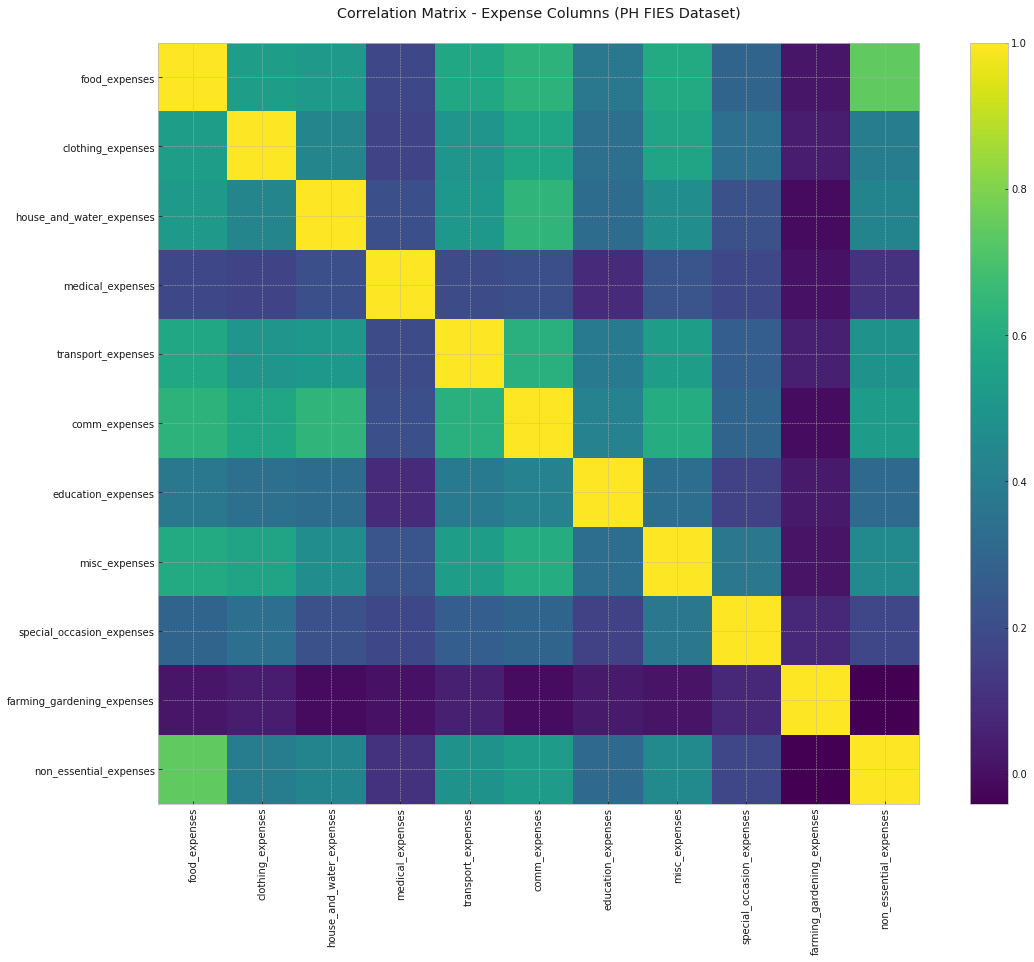

In [14]:
fig = plt.figure(figsize = (18, 14))
plt.xticks(np.arange(len(expense_corr.columns)), expense_corr.columns, rotation = 90)
plt.yticks(np.arange(len(expense_corr.index)), expense_corr.index)
plt.title('Correlation Matrix - Expense Columns (PH FIES Dataset)')
plt.imshow(expense_corr)
plt.colorbar()

In [15]:
income_ph_model.drop(['clothing_expenses',
                      'house_and_water_expenses', 
                      'medical_expenses',
                      'transport_expenses',
                      'comm_expenses',
                      'education_expenses',
                      'misc_expenses',
                      'special_occasion_expenses',
                      'non_essential_expenses'],
                     axis = 1,
                     inplace = True)

In [16]:
income_ph_model.drop(['house_singl_family',
                      'house_head_single',
                      'roof_material_strong',
                      'wall_material_strong',
                      'ws_other_toilet'],
                     axis = 1,
                     inplace = True)

Let's now examine the correlation matrix for the remaining fields:

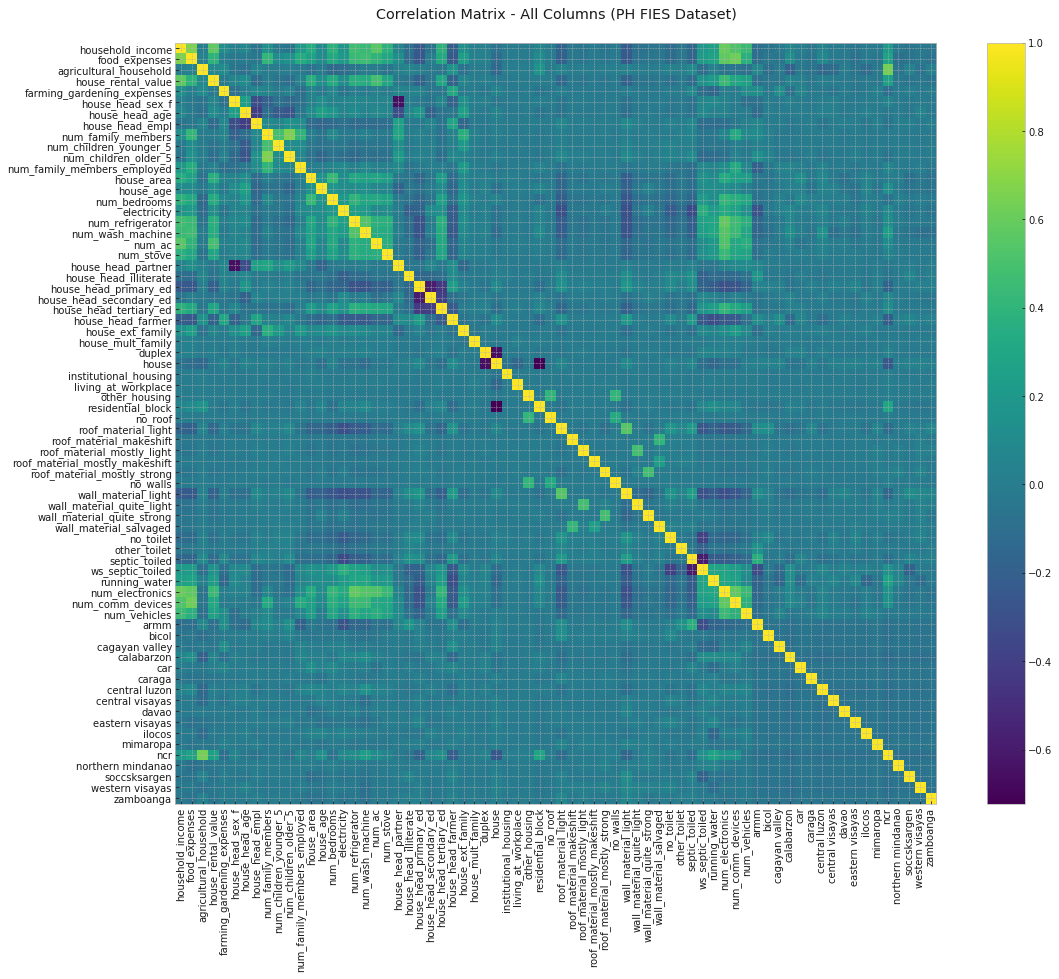

In [17]:
fig = plt.figure(figsize = (18, 14))
plt.title('Correlation Matrix - All Columns (PH FIES Dataset)')
plt.xticks(np.arange(len(income_ph_model.corr().columns)), income_ph_model.corr().columns, rotation = 90)
plt.yticks(np.arange(len(income_ph_model.corr().index)), income_ph_model.corr().index)
plt.imshow(income_ph_model.corr())
plt.colorbar()

At this point, we can derive an initial model. We'll use that model and its highest-performing features in order to reduce the number of input columns later on.

## Initial Model Selection
We will separate the data into a training and testing sets. We will only use the training set with cross validation in order to select the best fields. We will then use the test set to evaluate the final model's performance. The specific steps we will perform are:

1. Scaling and normalizing the data
2. Dividing the data into a training and testing sets
3. Evaluating an initial model
4. Selecting the columns with the highest weights
5. Creating the final model
6. Measuring the model's performance

We start by normalizing the data and splitting it into a train and test sets.

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, normalize

scaled_income_ph_model = pd.DataFrame(normalize(income_ph_model), columns = income_ph_model.columns)
scaled_income_ph_model.head()

X_train, X_test, y_train, y_test = train_test_split(scaled_income_ph_model.drop('household_income', axis = 1),\
                                                    scaled_income_ph_model.household_income,\
                                                    test_size = 0.3,\
                                                    random_state = 42)

X_train.head()

,food_expenses,agricultural_household,house_rental_value,farming_gardening_expenses,house_head_sex_f,house_head_age,house_head_empl,num_family_members,num_children_younger_5,num_children_older_5,...,central visayas,davao,eastern visayas,ilocos,mimaropa,ncr,northern mindanao,soccsksargen,western visayas,zamboanga
8870,0.473942,0.000000,0.000000,0.000000,0.000000e+00,0.000141,5.881118e-06,0.000018,0.000006,0.000000e+00,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12871,0.304237,0.000007,0.032391,0.304804,0.000000e+00,0.000371,6.748225e-06,0.000034,0.000000,2.024468e-05,...,0.0,0.000007,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10982,0.413686,0.000000,0.118103,0.000000,0.000000e+00,0.000191,5.623940e-06,0.000028,0.000011,5.623940e-06,...,0.0,0.000006,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
34137,0.105307,0.000000,0.033985,0.000000,6.663665e-07,0.000042,6.663665e-07,0.000004,0.000002,6.663665e-07,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4097,0.503581,0.000007,0.102249,0.287148,0.000000e+00,0.000300,6.816576e-06,0.000041,0.000007,1.363315e-05,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
print('The training data contains {} rows and {} columns'.format(X_train.shape[0], X_train.shape[1]))
valid_len = 9000

The training data contains 29080 rows and 69 columns


At this point we'll train and validate several model types without any tweaking. We'll do that on portions of the training dataset. We'll then produce some performance metrics that will allow us to focus on one or two of the models. For the purpose of benchmarking, we will also include validation results for three dummy regressors that always predict 0, 0.5 and 1 respectively.

In [20]:
class DummyRegressor:
    def __init__ (self, pred_val = 1.):
        self.pred_val = pred_val
    
    def fit (self, X, y):
        pass
    
    def predict (self, X):
        return [[self.pred_val] for i in range(X.shape[0])]

In [21]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.linear_model import SGDRegressor, LinearRegression
from sklearn import tree
from sklearn.metrics import mean_squared_error, r2_score, mean_squared_log_error, explained_variance_score

regressors = [AdaBoostRegressor, SVR, SGDRegressor, tree.DecisionTreeRegressor, LinearRegression, MLPRegressor]
regressor_names = ['ada_boost', 'svr', 'sgd', 'decision_tree', 'linear', 'mlp']
metric_names = ['mean_squared_error', 'r2_score', 'mean_squared_log_error', 'explained_variance_score']
scorers = [mean_squared_error, r2_score, mean_squared_log_error, explained_variance_score]

valid_res = pd.DataFrame(columns = ['regressor'] + metric_names)

#Calculate the selected regressor results
for r, r_name, i in zip(regressors, regressor_names, range(len(regressor_names))):
    clf = r()
    clf.fit(X_train[valid_len:], y_train[valid_len:])
    
    metrics = []
    for scorer in scorers:
        metrics.append(scorer(y_train[:valid_len], clf.predict(X_train[:valid_len])))
    
    valid_res.loc[i] = [r_name] + metrics

valid_res_dummy = pd.DataFrame(columns = ['regressor'] + metric_names)
dummy_vals = (0., 0.5, 1)

#Append the dummy regressor results
for v, i in zip(dummy_vals, range(len(dummy_vals))):
    clf = DummyRegressor(v)
    metrics = []
    for scorer in scorers:
        metrics.append(scorer(y_train[:valid_len], clf.predict(X_train[:valid_len])))
    
    valid_res_dummy.loc[i] = ['dummy_%s' % v] + metrics

valid_res = valid_res.append(valid_res_dummy, ignore_index = True)
valid_res

,regressor,mean_squared_error,r2_score,mean_squared_log_error,explained_variance_score
0,ada_boost,0.000495,0.900082,0.000138,9.078032e-01
1,svr,0.006065,-0.224031,0.001748,8.131763e-01
2,sgd,0.001648,0.667385,0.000497,6.680623e-01
3,decision_tree,0.000026,0.994757,0.000009,9.947591e-01
4,linear,0.000425,0.914236,0.000132,9.142700e-01
5,mlp,0.000154,0.968985,0.000050,9.695265e-01
6,dummy_0.0,0.797975,-160.057695,0.406124,0.000000e+00
7,dummy_0.5,0.157458,-30.780255,0.054666,0.000000e+00
8,dummy_1,0.016941,-2.419269,0.004708,-2.220446e-16


As we can see, the Decision Tree and the Multi Layer Perceptron regressor, the Liear Regression and AdaBoost regressors are performing best out of the box. Let's look at their feature importances (or in the case of the Linear Regression and the Multi Layer Perceptron regressor, the feature coefficients):

In [22]:
regressors = [AdaBoostRegressor, tree.DecisionTreeRegressor, LinearRegression, MLPRegressor]
regressor_names = ['ada_boost', 'decision_tree', 'linear', 'mlp']

top_n_features = 10

for r, r_name in zip(regressors, regressor_names):
    clf = r()
    clf.fit(X_train[valid_len:], y_train[valid_len:])
    if r_name == 'linear':
        feature_importances = pd.Series(clf.coef_, index = X_train.columns)
    elif r_name == 'mlp':
        all_features = pd.DataFrame(clf.coefs_[0], index = X_train.columns)
        feature_importances = all_features.ix[:, 0]
    else:
        feature_importances = pd.Series(clf.feature_importances_, index = X_train.columns)
    
    print('The top %s feature importances for the %s are:' % (top_n_features, r_name))
    display(feature_importances.sort_values(ascending = False)[:top_n_features])

The top 10 feature importances for the ada_boost are:


food_expenses                 0.746080
farming_gardening_expenses    0.190137
house_rental_value            0.054040
agricultural_household        0.006358
house_area                    0.000921
armm                          0.000863
house_head_partner            0.000654
house_head_empl               0.000499
num_family_members            0.000448
house_ext_family              0.000000
dtype: float64

The top 10 feature importances for the decision_tree are:


food_expenses                 0.633174
farming_gardening_expenses    0.348978
house_rental_value            0.016541
house                         0.000121
house_head_empl               0.000114
agricultural_household        0.000082
house_head_age                0.000076
num_wash_machine              0.000074
house_head_primary_ed         0.000071
house_age                     0.000063
dtype: float64

The top 10 feature importances for the linear are:


no_roof              2257.823560
ncr                   750.759429
car                   694.030488
zamboanga             669.261060
duplex                536.816816
other_toilet          509.406187
num_refrigerator      471.154704
davao                 469.813611
house                 466.653182
residential_block     434.856590
dtype: float64

The top 10 feature importances for the mlp are:


roof_material_mostly_makeshift    0.000040
roof_material_makeshift           0.000035
house_head_sex_f                  0.000032
residential_block                 0.000031
wall_material_light               0.000018
num_stove                         0.000013
farming_gardening_expenses        0.000008
house_head_empl                   0.000005
bicol                             0.000004
no_walls                          0.000003
Name: 0, dtype: float64

We can draw some conclusions the feature importance rankings, namely:

* The `food_expenses` variable has the highest weight in both the AdaBoost and the Decision Tree models. This seems to be reasonable as low income families have predominantly food expenses that they need to limit due to their situation.
* The `farming_gardening_expenses` has the second highest weight in both the AdaBoost and the Decision Tree models. This is also is in line with the general reasoning for poor households - they are mostly rural and within farming communities. Actually the Kiva dataset for loan themes contains a rural percentage column (supposedly for the same reason).
* There are other important indicators of poverty which also seem in line with our intuition. Such are:
    * Number of communication devices (or lack thereof)
    * Agricultural household indicator
    * House area
    * House head employment status
    * House head having partner indicator
    * Number of family members

It's also interesting to note that the Linear Regression has placed high importance on the regions and the living conditons (the `no_roof`, `other_toilet`, `num_refrigerator`). Unfortunately we cannot simply use the region features because that would make the model harder to scale in the future (such a model will be basically a map of poverty-stricken regions).

The MLP regressor (at least in one of the dimensions if its matrix) has selected a mix of features, namely:

* Expenses: `farming_gardening_expenses`
* Demographics: `num_children_older_5`, `house_head_secondary_ed`, `house_head_tertiary_ed`
* Living conditions: `house_ext_family`, `wall_material_quite_light`, `residential_block`, `roof_material_light`
* Region: `armm`

Here, we have some features that we can work with and some features that would be difficult to implement. One aspect of the MLP regressor that is disadvantageous for us is the difficulty in understanding its decision matrix (let's remember that these are the weights of just one perceptron out of 100 in the first layer). At least we get a partial confirmation that the `food_expenses` column is a very important feature.

## Final Model Selection and Testing

Having a better understanding of the feature importances, the successful initial models and the validity of our approach, we can now proceed and derive the final model. To do that, we will:

1. Select the model
2. Select 3 features based on the following criteria:
    * Feature weight
    * Feature applicability (how easy would be for Kiva to integrate such a question into their loan application form)
3. Retrain the model on the selected features.
4. Test the model performance on the test set.

We'll start first by selecting the model. Based on the performance table, derived above, it would seem reasonable to select the Decision Tree model. Another good reason for choosing it is that decision trees are easily explainable.

Next, we move on the the 3 features. Our choice is: `food_expenses`, `farming_gardening_expenses` and `agricultural_household`. We prefer the agricultural_household feature as it seems easier to apply in the field, however its weight is less than 1% of our model's prediction power, so we can drop it altogether.

We'll now produce the new featureset.

In [23]:
final_features = ['food_expenses', 'farming_gardening_expenses']

X_train, X_test = X_train[final_features], X_test[final_features]
X_train.head()

,food_expenses,farming_gardening_expenses
8870,0.473942,0.000000
12871,0.304237,0.304804
10982,0.413686,0.000000
34137,0.105307,0.000000
4097,0.503581,0.287148


We'll now retrain our model.

In [24]:
final_clf = tree.DecisionTreeRegressor(random_state = 42)
final_clf.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best')

We'll now assess the performance after retraining (we are expecting a slight drop in performance because we limited ourselves to 2 features).

In [25]:
metrics = pd.DataFrame(columns = ['metric', 'value'])

for metric, scorer, i in zip(metric_names, scorers, range(len(metric_names))):
    for set_type, set_data in zip(('train', 'test'), ([y_train, X_train], [y_test, X_test])):
        metrics.loc[i] = [metric + '_' + set_type, scorer(set_data[0], final_clf.predict(set_data[1]))]

metrics

,metric,value
0,mean_squared_error_test,0.000203
1,r2_score_test,0.961063
2,mean_squared_log_error_test,0.000056
3,explained_variance_score_test,0.961065


We'll now create a prediction for all results and derive the poverty score.

# Poverty Score

At this point the score is simply the inverse of the normalized `household_income`. That is, if the income is 80% if the highest value, the poverty is 20%. In the future, as we add more countries to the estimation, our poverty score will more and more reflect global levels.

We'll start by combining all predictions and producing a description of the resulting poverty score.

In [35]:
pred_train = pd.DataFrame(final_clf.predict(X_train), index = X_train.index, columns = ['inc_pred'])
pred_test = pd.DataFrame(final_clf.predict(X_test), index = X_test.index, columns = ['inc_pred'])

all_predictions = pred_train.append(pred_test)

all_predictions['poverty_score'] = 1 - all_predictions['inc_pred']
all_predictions.describe()

,inc_pred,poverty_score
count,41544.000000,41544.000000
mean,0.890068,0.109932
std,0.071839,0.071839
min,0.103609,0.000511
25%,0.853509,0.056976
50%,0.903322,0.096678
75%,0.943024,0.146491
max,0.999489,0.896391


# Poverty Score and Kiva Loan Data Merge
Let's now briefly see how the predicted poverty distribution compares to the distribution of the actual income data.

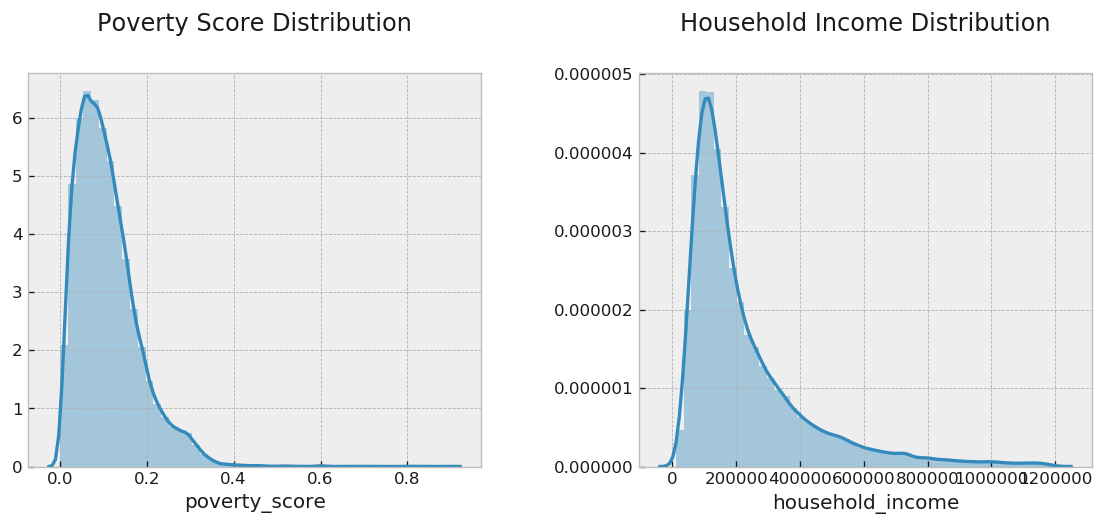

In [49]:
fig = plt.figure(figsize = (18, 10), dpi = 120)
fig.subplots_adjust(hspace = 0.3, wspace = 0.35)

ax1 = fig.add_subplot(2, 3, 1)
ax1.set_title('Poverty Score Distribution')
sns.distplot(all_predictions.poverty_score, label = 'inc_pred')

ax2 = fig.add_subplot(2, 3, 2)
ax2.set_title('Household Income Distribution')
sns.distplot(income_ph_model.household_income[income_ph_model.household_income < 1200000])

We will now join the region and house head feamale indicators from the original FIES data set. This will allow us to merge the poverty score with the Kiva loans data based on region and gender (as prescribed by the rules of the Kiva challenge).

In [37]:
all_predictions = all_predictions.join(income_ph[['region', 'house_head_sex_f']])
all_predictions.head()

,inc_pred,poverty_score,region,house_head_sex_f
8870,0.880556,0.119444,calabarzon,0
12871,0.901972,0.098028,davao,0
10982,0.902727,0.097273,davao,0
34137,0.993740,0.006260,caraga,1
4097,0.808391,0.191609,car,0


Let's now visualize the distribution of the poverty score by region and gender.

Text(0.5,1,'Poverty Score by Region and Gender')

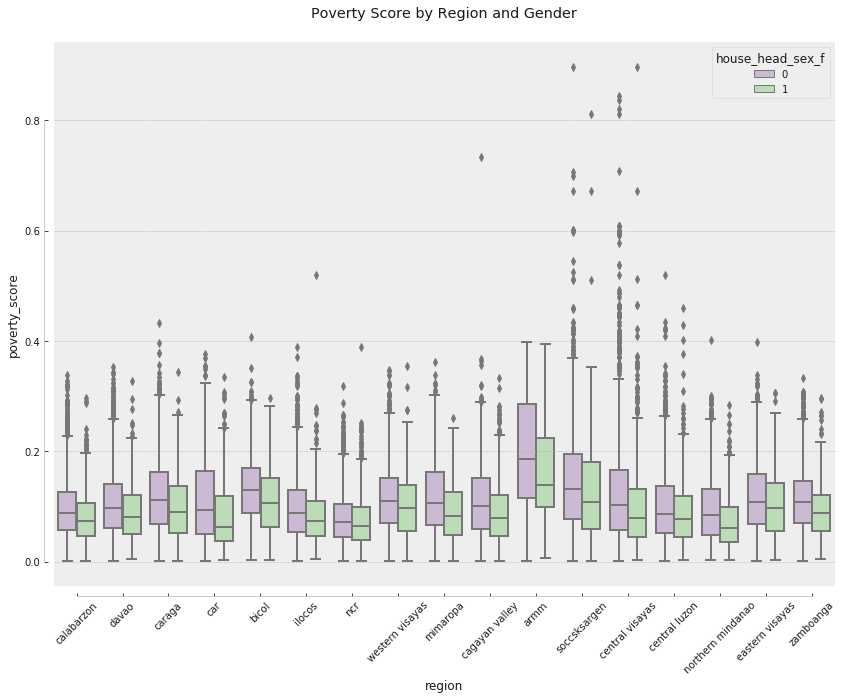

In [50]:
sns.boxplot(x = 'region', y = 'poverty_score', hue = 'house_head_sex_f', data = all_predictions, palette = "PRGn")
sns.despine(offset=10, trim=True)
plt.xticks(rotation = 45)
plt.title('Poverty Score by Region and Gender')

As we can see, the Visayas Island, the Soccsksargen province and the Administrative Region of Muslim Mindanao score consistently high in poverty score, compared to other regions. The interesting thing about Visayas is that, even though, the median, the 25th and 75th percentiles are within the country levels, there is a noticable streak of outliers with extreme poverty scores.

We will now group the predictions by region and house head gender. In this grouping we'll take the mean value, although other measures could aslo be used. Another approach to the grouping could be to take the maximum poverty score for assessment of the worst affected areas.

In [39]:
predictions_grouped = all_predictions.drop('inc_pred', axis = 1).groupby(by = ['region', 'house_head_sex_f']).mean().reset_index()

Text(0.5,1,'Poverty Score by Region')

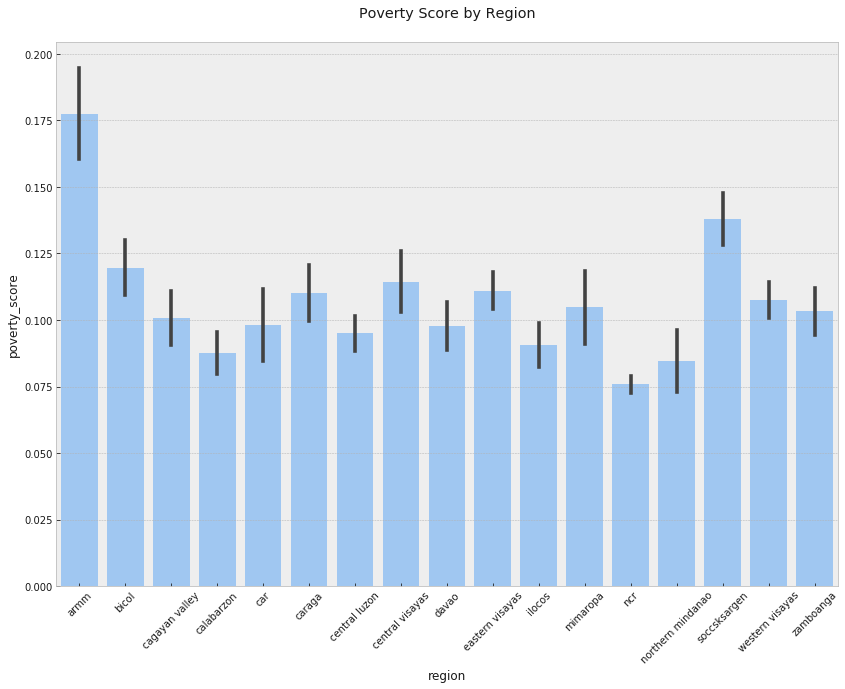

In [51]:
sns.barplot(x = 'region', y = 'poverty_score', data = predictions_grouped, color = 'b')
plt.xticks(rotation = 45)
plt.title('Poverty Score by Region')

We will now merge the Kiva loans dataset and the grouped poverty score by region and house head gender (in the context of Kiva loans - borrower gender). At this point we can also save the merged data.

In [41]:
merged_loans = pd.merge(left = loans_ph, right = predictions_grouped, how = 'left', on = ['region', 'house_head_sex_f'])
merged_loans.to_csv('kiva_loans_plus_poverty_score.csv')

In [42]:
merged_loans.head()

,id,funded_amount,loan_amount,activity,sector,use,country_code,country,location,currency,...,disbursed_time,funded_time,term_in_months,lender_count,tags,house_head_sex_f,repayment_interval,date,region,poverty_score
0,653149,175.0,175.0,Pigs,Agriculture,to purchase feed and vitamins for her pigs,PH,Philippines,"Tanjay, Negros Oriental",PHP,...,2013-12-06 08:00:00+00:00,2014-01-02 07:47:28+00:00,8.0,7,NaN,1,irregular,2014-01-02,central visayas,0.103142
1,653123,700.0,700.0,General Store,Retail,"to buy additional items like eggs, charcoal, r...",PH,Philippines,"Brookes Point, Palawan",PHP,...,2013-12-10 08:00:00+00:00,2014-01-02 03:26:10+00:00,5.0,2,NaN,1,irregular,2014-01-02,mimaropa,0.091168
2,653338,575.0,575.0,Farming,Agriculture,to purchase fertilizers and other farm supplies,PH,Philippines,"Tanjay, Negros Oriental",PHP,...,2013-12-05 08:00:00+00:00,2014-01-02 23:01:23+00:00,8.0,19,NaN,1,irregular,2014-01-02,central visayas,0.103142
3,653242,325.0,325.0,General Store,Retail,"to purchase sugar, coffee, coffee creamer, can...",PH,Philippines,"Sinippil, Cauayan City, Isabela",PHP,...,2013-12-13 08:00:00+00:00,2014-01-02 17:50:06+00:00,7.0,11,volunteer_pick,1,irregular,2014-01-02,cagayan valley,0.090570
4,653134,575.0,575.0,Pigs,Agriculture,to purchase additional feed for her pigs.,PH,Philippines,"Brookes Point, Palawan",PHP,...,2013-12-09 08:00:00+00:00,2014-01-02 14:47:08+00:00,8.0,20,NaN,1,irregular,2014-01-02,mimaropa,0.091168


We can now load the Kiva MPI region locations dataset, remap the Philippines region names to our existing naming convention and join the latitude and longitude for each region (this will allow us to make some map plots). We'll also save this file.

In [44]:
loan_regions = pd.read_csv('kiva_mpi_region_locations.csv')
loan_regions.head()

loan_regions_ph = loan_regions[loan_regions.country == 'Philippines']
loan_regions_ph

region_mapping_phil_loans = {'National Capital Region' : 'ncr',\
                             'Cordillera Admin Region' : 'car',\
                             'Ilocos Region' : 'ilocos',\
                             'Cagayan Valley' : 'cagayan valley',\
                             'Central Luzon' : 'central luzon',\
                             'Calabarzon' : 'calabarzon',\
                             'Mimaropa' : 'mimaropa',\
                             'Bicol Region' : 'bicol',\
                             'Western Visayas' : 'western visayas',\
                             'Central Visayas' : 'central visayas',\
                             'Eastern Visayas' : 'eastern visayas',\
                             'Zamboanga Peninsula' : 'zamboanga',\
                             'Northern Mindanao' : 'northern mindanao',\
                             'Davao Peninsula' : 'davao',\
                             'Soccsksargen' : 'soccsksargen',\
                             'CARAGA' : 'caraga',\
                             'Armm' : 'armm'}

loan_regions_ph.region = loan_regions_ph.region.map(region_mapping_phil_loans)

merged_loans = merged_loans.merge(loan_regions_ph, how = 'left', on = ['region'])
merged_loans.to_csv('kiva_loans_plus_poverty_score_regional_coordinates.csv')

We'll now create a small dataframe for visualizing the relationship between the mean Kiva loan amount in each region and its corresponding mean poverty score. This could help us identify areas where Kiva can invest more and have additional positive impact.

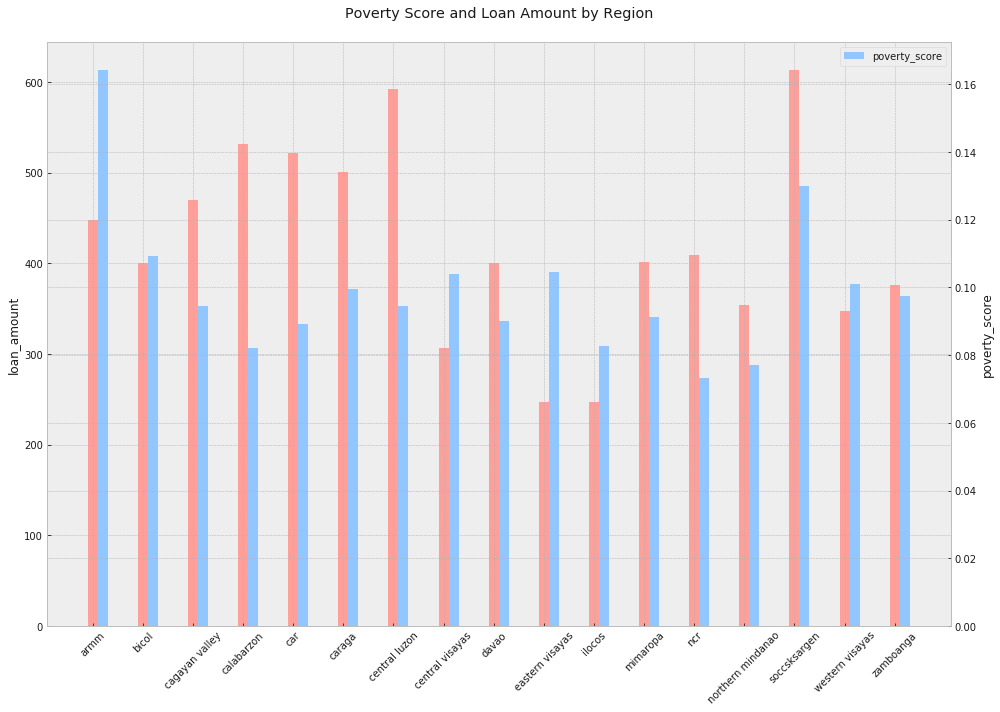

In [52]:
vis_loans = merged_loans[['loan_amount', 'poverty_score', 'lat', 'lon', 'region']].groupby(by = 'region').mean().reset_index()

fig, ax1 = plt.subplots()
ax1.bar(np.arange(len(vis_loans)), vis_loans.loan_amount, align = 'center', label = 'loan_amount', width = 0.2, color = 'r')

ax1.set_xticks(np.arange(len(vis_loans)))
ax1.set_xticklabels(vis_loans.region, rotation = 45)

ax2 = ax1.twinx()
ax2.bar(np.arange(len(vis_loans)) + 0.2, vis_loans.poverty_score, align = 'center', label = 'poverty_score', width = 0.2, color = 'b')
plt.legend()
ax1.set_ylabel('loan_amount')
ax2.set_ylabel('poverty_score')
plt.title('Poverty Score and Loan Amount by Region')
fig.tight_layout()

Finally we can visualize the maximum poverty score for each province by the radius of the circles on the following map (the latitude and longitude provided by Kiva are used for placing the circles in each region):

In [53]:
vis_loans = merged_loans[['loan_amount', 'poverty_score', 'lat', 'lon', 'region']].groupby(by = 'region').max().reset_index()

m = folium.Map(location = [13.5, 119], tiles = 'Mapbox Bright', zoom_start = 5.8)
for i in range(0, len(vis_loans)):
    folium.Circle(\
                  location = [vis_loans.iloc[i].lat ,\
                              vis_loans.iloc[i].lon],\
                  radius = vis_loans.iloc[i].poverty_score * 250000,\
                  color = 'red',\
                  fill = True,\
                  stroke = False,\
                  fillOpacity = .2
   ).add_to(m)
    
'''    folium.Circle(\
                  location = [vis_loans.iloc[i].lat ,\
                              vis_loans.iloc[i].lon],\
                  radius = vis_loans.iloc[i].loan_amount * 50,\
                  color = 'blue',\
                  fill = True,\
                  stroke = False,\
                  fillOpacity = .2
   ).add_to(m)'''

mapWidth, mapHeight = (400, 500)
m

# Conclusions and Future Improvement

In this notebook, we focused on Kiva data for loans granted in the Philippines. We did so as the Philippines accounts for the highest number of loans in the Kiva dataset. We used pre-processed data from the Filippino Famili Income and Expenditure Survey. We derived household income prediction based on the FIES data and inverted the normalized prediction to get a poverty score. We then joined the mean poverty score results to the Kiva loan dataset by gender and region.

Unfortunately our current work doesn't cover other countries. That's why the potential future improvements on this work could be:

* Identify and pre-process data for other regions (e.g. Kenya)
* Derive the currently selected poverty predictors (food expenses and farming expenses)
* Retrain the model as each new country is added and backpropagate the poverty scores

Thank you for your attention.